In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

100%|██████████| 7385/7385 [00:10<00:00, 685.21it/s]



Epoch 001: Train Loss = 1.3561, Val Loss = 2.9601
Epoch 002: Train Loss = 0.9482, Val Loss = 2.7763
Epoch 002: Train Loss = 0.9482, Val Loss = 2.7763
Epoch 003: Train Loss = 0.9317, Val Loss = 2.9701
Epoch 003: Train Loss = 0.9317, Val Loss = 2.9701
Epoch 004: Train Loss = 0.9217, Val Loss = 4.2948
Epoch 004: Train Loss = 0.9217, Val Loss = 4.2948
Epoch 005: Train Loss = 0.9101, Val Loss = 3.8598
Epoch 005: Train Loss = 0.9101, Val Loss = 3.8598
Epoch 006: Train Loss = 0.8923, Val Loss = 6.9986
Epoch 006: Train Loss = 0.8923, Val Loss = 6.9986
Epoch 007: Train Loss = 0.8819, Val Loss = 5.7359
Epoch 007: Train Loss = 0.8819, Val Loss = 5.7359
Epoch 008: Train Loss = 0.8647, Val Loss = 7.2252
Epoch 008: Train Loss = 0.8647, Val Loss = 7.2252
Epoch 009: Train Loss = 0.8567, Val Loss = 9.9842
Epoch 009: Train Loss = 0.8567, Val Loss = 9.9842
Epoch 010: Train Loss = 0.8403, Val Loss = 8.3842
Epoch 010: Train Loss = 0.8403, Val Loss = 8.3842
Epoch 011: Train Loss = 0.8263, Val Loss = 9.3808


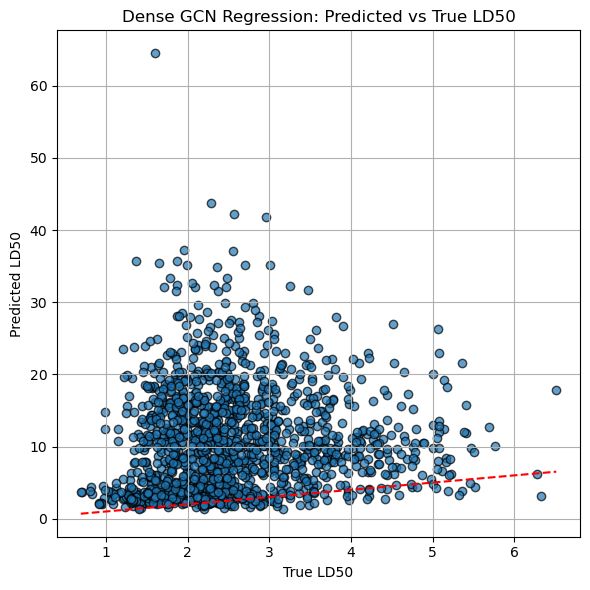

In [10]:
import pandas as pd
import torch
from rdkit import Chem
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rdkit.Chem import rdchem

# Load dataset
df = pd.read_csv('ld50_zhu.tab', sep='\t')

# Helper function for one-hot encoding
def one_hot_encoding(value, choices):
    return [float(value == choice) for choice in choices]

# Atom feature function (enhanced)
def atom_features(atom):
    atom_type_list = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'H', 'Unknown']
    hybridization_list = [
        rdchem.HybridizationType.SP,
        rdchem.HybridizationType.SP2,
        rdchem.HybridizationType.SP3,
        rdchem.HybridizationType.SP3D,
        rdchem.HybridizationType.SP3D2
    ]

    symbol = atom.GetSymbol()
    symbol = symbol if symbol in atom_type_list else 'Unknown'

    features = []
    features += one_hot_encoding(symbol, atom_type_list)
    features += one_hot_encoding(atom.GetDegree(), list(range(6)))
    features.append(atom.GetFormalCharge())
    features += one_hot_encoding(atom.GetHybridization(), hybridization_list)
    features.append(float(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetNumImplicitHs(), list(range(5)))
    features += one_hot_encoding(atom.GetChiralTag(), [
        rdchem.ChiralType.CHI_UNSPECIFIED,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        rdchem.ChiralType.CHI_OTHER
    ])
    features.append(float(atom.IsInRing()))
    features.append(atom.GetMass() * 0.01)  # Scaled atomic mass

    return torch.tensor(features, dtype=torch.float)

# Bond feature function
def bond_features(bond):
    bond_type_list = [
        rdchem.BondType.SINGLE,
        rdchem.BondType.DOUBLE,
        rdchem.BondType.TRIPLE,
        rdchem.BondType.AROMATIC
    ]

    features = []
    features += one_hot_encoding(bond.GetBondType(), bond_type_list)
    features.append(float(bond.GetIsConjugated()))
    features.append(float(bond.IsInRing()))
    return torch.tensor(features, dtype=torch.float)

# SMILES to graph with dense adjacency matrix
def mol_to_dense_graph_data(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    num_atoms = mol.GetNumAtoms()
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # Dense adjacency matrix: shape [num_atoms, num_atoms, num_edge_features]
    num_edge_features = len(bond_features(mol.GetBondWithIdx(0))) if mol.GetNumBonds() > 0 else 6
    adj = torch.zeros((num_atoms, num_atoms, num_edge_features), dtype=torch.float)

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        f = bond_features(bond)
        adj[i, j] = f
        adj[j, i] = f  # Bidirectional

    y = torch.tensor([label], dtype=torch.float)
    return {'x': x, 'adj': adj, 'y': y}

# Convert all data
graph_data_list = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    data = mol_to_dense_graph_data(row['X'], row['Y'])
    if data:
        graph_data_list.append(data)

# Split dataset
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Dense GCN Layer ---
class DenseGCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(DenseGCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x, adj):
        # x: [N, F], adj: [N, N] (binary or weighted)
        # Add self-loops
        adj = adj.clone()
        N = adj.size(0)
        adj = adj + torch.eye(N, device=adj.device)
        # Normalize adjacency
        deg = adj.sum(dim=1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        D_inv_sqrt = torch.diag(deg_inv_sqrt)
        adj_norm = D_inv_sqrt @ adj @ D_inv_sqrt
        # GCN propagation
        x = self.linear(x)
        out = adj_norm @ x
        return out

# --- Model using Dense GCN Layers ---
class DenseGCNRegressor(nn.Module):
    def __init__(self, num_node_features, hidden_dim=64):
        super(DenseGCNRegressor, self).__init__()
        self.gcn1 = DenseGCNLayer(num_node_features, hidden_dim)
        self.gcn2 = DenseGCNLayer(hidden_dim, hidden_dim)
        self.gcn3 = DenseGCNLayer(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
    def forward(self, x, adj):
        # Convert edge feature adj to binary adjacency for GCN
        adj_bin = (adj.sum(dim=2) > 0).float()  # [N, N]
        h = F.relu(self.bn1(self.gcn1(x, adj_bin)))
        h = self.dropout(h)
        h = F.relu(self.bn2(self.gcn2(h, adj_bin)))
        h = self.dropout(h)
        h = F.relu(self.bn3(self.gcn3(h, adj_bin)))
        h = self.dropout(h)
        h = h.mean(dim=0, keepdim=True)
        h = F.relu(self.fc1(h))
        out = self.fc2(h)
        return out.squeeze()

# DataLoader for dense graphs
class DenseGraphDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        return self.data_list[idx]

def dense_collate(batch):
    xs = [item['x'] for item in batch]
    adjs = [item['adj'] for item in batch]
    ys = torch.stack([item['y'] for item in batch])
    return xs, adjs, ys

train_dataset = DenseGraphDataset(train_data)
test_dataset = DenseGraphDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=dense_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=dense_collate)

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for xs, adjs, ys in loader:
        optimizer.zero_grad()
        batch_preds = []
        for x, adj in zip(xs, adjs):
            x, adj = x.to(device), adj.to(device)
            pred = model(x, adj)
            batch_preds.append(pred)
        preds = torch.stack(batch_preds)
        loss = criterion(preds.view(-1), ys.view(-1).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xs)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xs, adjs, ys in loader:
            batch_preds = []
            for x, adj in zip(xs, adjs):
                x, adj = x.to(device), adj.to(device)
                pred = model(x, adj)
                batch_preds.append(pred)
            preds = torch.stack(batch_preds)
            loss = criterion(preds.view(-1), ys.view(-1).to(device))
            total_loss += loss.item() * len(xs)
    return total_loss / len(loader.dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = graph_data_list[0]['x'].shape[1]
model = DenseGCNRegressor(num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(1, 51):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xs, adjs, ys in loader:
            batch_preds = []
            for x, adj in zip(xs, adjs):
                x, adj = x.to(device), adj.to(device)
                pred = model(x, adj)
                batch_preds.append(pred.cpu().numpy())
            y_true.extend(ys.view(-1).cpu().numpy())
            y_pred.extend(batch_preds)
    return np.array(y_true), np.array(y_pred).flatten()

y_true, y_pred = get_predictions(model, test_loader, device)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Evaluation Metrics on Test Set:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True LD50")
plt.ylabel("Predicted LD50")
plt.title("Dense GCN Regression: Predicted vs True LD50")
plt.grid(True)
plt.tight_layout()
plt.show()

100%|██████████| 7385/7385 [00:11<00:00, 637.94it/s]



Converted 7385 / 7385 molecules to graphs
Starting training. Device: cuda
Epoch 001 / 050 - Train: 0.9472  Val: 0.7103
Epoch 001 / 050 - Train: 0.9472  Val: 0.7103
Epoch 002 / 050 - Train: 0.6757  Val: 0.5365
Epoch 002 / 050 - Train: 0.6757  Val: 0.5365
Epoch 003 / 050 - Train: 0.6346  Val: 0.5162
Epoch 003 / 050 - Train: 0.6346  Val: 0.5162
Epoch 004 / 050 - Train: 0.6069  Val: 0.5379
Epoch 004 / 050 - Train: 0.6069  Val: 0.5379
Epoch 005 / 050 - Train: 0.5917  Val: 0.5053
Epoch 005 / 050 - Train: 0.5917  Val: 0.5053
Epoch 006 / 050 - Train: 0.5885  Val: 0.5178
Epoch 006 / 050 - Train: 0.5885  Val: 0.5178
Epoch 007 / 050 - Train: 0.5649  Val: 0.4736
Epoch 007 / 050 - Train: 0.5649  Val: 0.4736
Epoch 008 / 050 - Train: 0.5748  Val: 0.4755
Epoch 008 / 050 - Train: 0.5748  Val: 0.4755
Epoch 009 / 050 - Train: 0.5597  Val: 0.5320
Epoch 009 / 050 - Train: 0.5597  Val: 0.5320
Epoch 010 / 050 - Train: 0.5558  Val: 0.4650
Epoch 010 / 050 - Train: 0.5558  Val: 0.4650
Epoch 011 / 050 - Train: 0

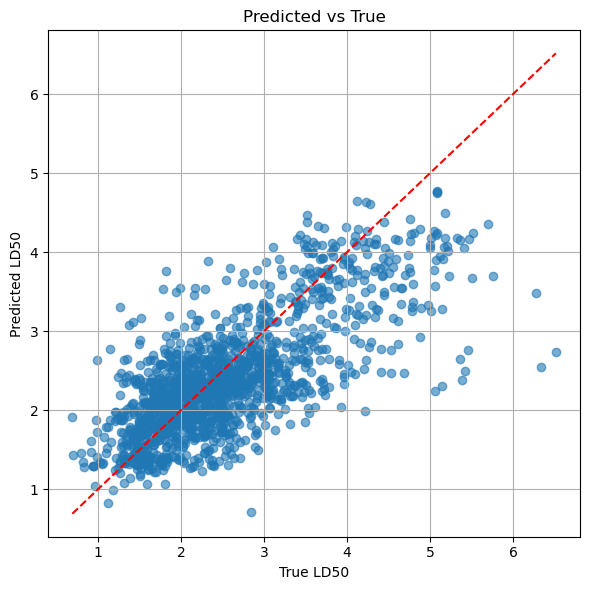

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import rdchem
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# ---------------------------
# Helpers
# ---------------------------
def one_hot_encoding(value, choices):
    # return list of floats of length len(choices)
    return [1.0 if value == c else 0.0 for c in choices]

# Atom feature function (enhanced, fixed)
def atom_features(atom):
    atom_type_list = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'H', 'Unknown']
    hybridization_list = [
        rdchem.HybridizationType.SP,
        rdchem.HybridizationType.SP2,
        rdchem.HybridizationType.SP3,
        rdchem.HybridizationType.SP3D,
        rdchem.HybridizationType.SP3D2
    ]

    symbol = atom.GetSymbol()
    symbol = symbol if symbol in atom_type_list else 'Unknown'

    features = []
    features += one_hot_encoding(symbol, atom_type_list)
    # degree: limit to 0..5 (if >5 -> all zeros)
    features += one_hot_encoding(atom.GetDegree(), list(range(6)))
    features.append(float(atom.GetFormalCharge()))
    # hybridization: check if in list; if not, all zeros
    hyb = atom.GetHybridization()
    features += one_hot_encoding(hyb, hybridization_list)
    features.append(1.0 if atom.GetIsAromatic() else 0.0)
    features += one_hot_encoding(atom.GetNumImplicitHs(), list(range(5)))
    features += one_hot_encoding(atom.GetChiralTag(), [
        rdchem.ChiralType.CHI_UNSPECIFIED,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        rdchem.ChiralType.CHI_OTHER
    ])
    features.append(1.0 if atom.IsInRing() else 0.0)
    features.append(atom.GetMass() * 0.01)  # scaled atomic mass

    return torch.tensor(features, dtype=torch.float)

# Bond features
def bond_features(bond):
    bond_type_list = [
        rdchem.BondType.SINGLE,
        rdchem.BondType.DOUBLE,
        rdchem.BondType.TRIPLE,
        rdchem.BondType.AROMATIC
    ]
    bt = bond.GetBondType() if bond is not None else None
    features = []
    features += one_hot_encoding(bt, bond_type_list)
    features.append(1.0 if bond.GetIsConjugated() else 0.0)
    features.append(1.0 if bond.IsInRing() else 0.0)
    return torch.tensor(features, dtype=torch.float)

# ---------------------------
# SMILES -> Dense graph
# ---------------------------
def mol_to_dense_graph_data(smiles, label, verbose=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        if verbose:
            print("Invalid SMILES skipped:", smiles)
        return None

    num_atoms = mol.GetNumAtoms()
    if num_atoms == 0:
        if verbose:
            print("Empty molecule:", smiles)
        return None

    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # determine edge feature length (bond_features length)
    if mol.GetNumBonds() > 0:
        num_edge_features = bond_features(mol.GetBondWithIdx(0)).shape[0]
    else:
        # set default: 4 (bond types) + 1 conjugated + 1 in ring = 6
        num_edge_features = 6

    adj = torch.zeros((num_atoms, num_atoms, num_edge_features), dtype=torch.float)

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        f = bond_features(bond)
        adj[i, j] = f
        adj[j, i] = f

    y = torch.tensor([label], dtype=torch.float)
    return {'x': x, 'adj': adj, 'y': y}

# ---------------------------
# Load CSV and convert to graphs
# ---------------------------
df = pd.read_csv('ld50_zhu.tab', sep='\t')
graph_data_list = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    data = mol_to_dense_graph_data(row['X'], row['Y'])
    if data is not None:
        graph_data_list.append(data)

print(f"Converted {len(graph_data_list)} / {len(df)} molecules to graphs")

# quick sanity check
if len(graph_data_list) == 0:
    raise RuntimeError("No valid graphs created. Check SMILES column and RDKit installation.")

train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

# ---------------------------
# Model: replace BatchNorm1d with LayerNorm (per-node normalization)
# ---------------------------
class DenseGCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(DenseGCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x: [N, F], adj: [N, N] (float)
        N = adj.size(0)
        # add self loops
        adj = adj + torch.eye(N, device=adj.device)
        # normalize
        deg = adj.sum(dim=1)  # [N]
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
        D_inv_sqrt = torch.diag(deg_inv_sqrt)
        adj_norm = D_inv_sqrt @ adj @ D_inv_sqrt
        h = self.linear(x)  # [N, out_features]
        out = adj_norm @ h
        return out

class DenseGCNRegressor(nn.Module):
    def __init__(self, num_node_features, hidden_dim=64, dropout=0.3):
        super(DenseGCNRegressor, self).__init__()
        self.gcn1 = DenseGCNLayer(num_node_features, hidden_dim)
        self.gcn2 = DenseGCNLayer(hidden_dim, hidden_dim)
        self.gcn3 = DenseGCNLayer(hidden_dim, hidden_dim)
        # Use LayerNorm to be robust to variable N
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, adj):
        # convert edge-feature adj to binary adjacency
        if adj.dim() == 3:
            adj_bin = (adj.sum(dim=2) > 0).float()
        else:
            adj_bin = adj.float()

        h = F.relu(self.ln1(self.gcn1(x, adj_bin)))
        h = self.dropout(h)
        h = F.relu(self.ln2(self.gcn2(h, adj_bin)))
        h = self.dropout(h)
        h = F.relu(self.ln3(self.gcn3(h, adj_bin)))
        h = self.dropout(h)
        # global mean pooling over nodes
        h = h.mean(dim=0, keepdim=True)  # [1, hidden_dim]
        h = F.relu(self.fc1(h))
        out = self.fc2(h)
        return out.view(-1)  # flatten to shape [1] -> scalar

# ---------------------------
# Dataset, collate, loaders
# ---------------------------
class DenseGraphDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        return self.data_list[idx]

def dense_collate(batch):
    xs = [item['x'] for item in batch]
    adjs = [item['adj'] for item in batch]
    ys = torch.stack([item['y'] for item in batch]).view(-1)  # shape [batch]
    return xs, adjs, ys

train_dataset = DenseGraphDataset(train_data)
test_dataset = DenseGraphDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=dense_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=dense_collate)

# ---------------------------
# Train & eval helpers
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_node_features = graph_data_list[0]['x'].shape[1]
model = DenseGCNRegressor(num_node_features, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0
    for xs, adjs, ys in loader:
        optimizer.zero_grad()
        batch_preds = []
        ys = ys.to(device)
        for x, adj in zip(xs, adjs):
            x = x.to(device)
            adj = adj.to(device)
            pred = model(x, adj)  # returns tensor shape [1] or scalar
            batch_preds.append(pred)
        preds = torch.stack(batch_preds).view(-1)
        loss = criterion(preds, ys.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(xs)
        n_samples += len(xs)
    return running_loss / n_samples

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for xs, adjs, ys in loader:
            batch_preds = []
            ys = ys.to(device)
            for x, adj in zip(xs, adjs):
                x = x.to(device)
                adj = adj.to(device)
                pred = model(x, adj)
                batch_preds.append(pred)
            preds = torch.stack(batch_preds).view(-1)
            loss = criterion(preds, ys.float())
            running_loss += loss.item() * len(xs)
            n_samples += len(xs)
    return running_loss / n_samples

# ---------------------------
# Run training
# ---------------------------
n_epochs = 50
train_losses = []
val_losses = []

print("Starting training. Device:", device)
for epoch in range(1, n_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:03d} / {n_epochs:03d} - Train: {train_loss:.4f}  Val: {val_loss:.4f}")

# ---------------------------
# Predictions & metrics
# ---------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_predictions(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xs, adjs, ys in loader:
            batch_preds = []
            for x, adj in zip(xs, adjs):
                x = x.to(device)
                adj = adj.to(device)
                pred = model(x, adj)
                batch_preds.append(pred.cpu().item())
            y_true.extend(ys.cpu().numpy().tolist())
            y_pred.extend(batch_preds)
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_loader, device)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("Evaluation metrics on test set:")
print(f"MAE: {mae:.4f}  MSE: {mse:.4f}  RMSE: {rmse:.4f}  R2: {r2:.4f}")

# simple scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True LD50")
plt.ylabel("Predicted LD50")
plt.title("Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()
